# Set up the class fundementals 

In [1]:
# import os, sys
# import collections
import numpy as np
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import timeit
# import collections
from scipy.linalg import toeplitz, block_diag
from scipy.stats import median_abs_deviation as mad
# import multiprocessing
# import cProfile
# import itertools
from numba import jit, njit
import warnings
warnings.filterwarnings('ignore') # this is just to hide all the warnings
# import rpy2.robjects as robjects
# import matplotlib.pyplot as plt # change font globally to Times 
# plt.style.use('ggplot')
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times New Roman",
#     "font.sans-serif": ["Times New Roman"],
#     "font.size": 12})

# os.chdir(sys.path[0]) # ensure working direcotry is set same as the file

In [2]:
######################################  some SCAD and MCP things  #######################################
@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def soft_thresholding(x, lambda_):
    '''
    To calculate soft-thresholding mapping of a given ONE-DIMENSIONAL tensor, BESIDES THE FIRST TERM (so beta_0 will not be penalized). 
    This function is to be used for calculation involving L1 penalty term later. 
    '''
    return np.concatenate((np.array([x[0]]), np.where(np.abs(x[1:])>lambda_, x[1:] - np.sign(x[1:])*lambda_, 0)))

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD(x, lambda_, a=3.7):
    '''
    To calculate SCAD penalty value;
    #x can be a multi-dimensional tensor;
    lambda_, a are scalars;
    Fan and Li suggests to take a as 3.7 
    '''
    # here I notice the function is de facto a function of absolute value of x, therefore take absolute value first to simplify calculation 
    x = np.abs(x)
    temp = np.where(x<=lambda_, lambda_*x, np.where(x<a*lambda_, (2*a*lambda_*x - x**2 - lambda_**2)/(2*(a - 1)), lambda_**2 * (a+1)/2))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_grad(x, lambda_, a=3.7):
    '''
    To calculate the gradient of SCAD wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    # here decompose x to sign and its absolute value for easier calculation
    sgn = np.sign(x)
    x = np.abs(x)
    temp = np.where(x<=lambda_, lambda_*sgn, np.where(x<a*lambda_, (a*lambda_*sgn-sgn*x)/(a-1), 0))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP(x, lambda_, gamma):
    '''
    To calculate MCP penalty value; 
    #x can be a multi-dimensional tensor. 
    '''
    # the function is a function of absolute value of x 
    x = np.abs(x)
    temp = np.where(x<=gamma*lambda_, lambda_*x - x**2/(2*gamma), .5*gamma*lambda_**2)
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_grad(x, lambda_, gamma):
    '''
    To calculate MCP gradient wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    temp = np.where(np.abs(x)<gamma*lambda_, lambda_*np.sign(x)-x/gamma, np.zeros_like(x))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_concave(x, lambda_, a=3.7):
    '''
    The value of concave part of SCAD penalty; 
    #x can be a multi-dimensional tensor. 
    '''
    x = np.abs(x)
    temp = np.where(x<=lambda_, 0., np.where(x<a*lambda_, (lambda_*x - (x**2 + lambda_**2)/2)/(a-1), (a+1)/2*lambda_**2 - lambda_*x))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_concave_grad(x, lambda_, a=3.7):
    '''
    The gradient of concave part of SCAD penalty wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    sgn = np.sign(x)
    x = np.abs(x)
    temp = np.where(x<=lambda_, 0., np.where(x<a*lambda_, (lambda_*sgn-sgn*x)/(a-1), -lambda_*sgn))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_concave(x, lambda_, gamma):
    '''
    The value of concave part of MCP penalty; 
    #x can be a multi-dimensional tensor. 
    '''
    # similiar as in MCP
    x = np.abs(x)
    temp = np.where(x<=gamma*lambda_, -(x**2)/(2*gamma), (gamma*lambda_**2)/2 - lambda_*x)
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_concave_grad(x, lambda_, gamma):
    '''
    The gradient of concave part of MCP penalty wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    temp = np.where(np.abs(x) < gamma*lambda_, -x/gamma, -lambda_*np.sign(x))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 


# Implementation

In [3]:
@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def update_smooth_grad_convex(N, X, beta_md, y):
    '''
    Update the gradient of the smooth convex objective component.
    '''
    return 1/N*X.T@(X@beta_md - y)

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def update_smooth_grad_SCAD(N, X, beta_md, y, _lambda, a):
    '''
    Update the gradient of the smooth objective component for SCAD penalty.
    '''
    return update_smooth_grad_convex(N=N, X=X, beta_md=beta_md, y=y) + SCAD_concave_grad(x=beta_md, lambda_=_lambda, a=a)

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def update_smooth_grad_MCP(N, X, beta_md, y, _lambda, gamma):
    '''
    Update the gradient of the smooth objective component for MCP penalty.
    '''
    return update_smooth_grad_convex(N=N, X=X, beta_md=beta_md, y=y) + MCP_concave_grad(x=beta_md, lambda_=_lambda, gamma=gamma)

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def eval_obj_SCAD(N, X, beta_md, y, _lambda, a, x_temp):
    '''
    evaluate value of the objective function.
    '''
    error = y - X@x_temp
    return (error.T@error)/(2.*N) + np.sum(SCAD(x_temp, lambda_=_lambda, a=a))

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def eval_obj_MCP(N, X, beta_md, y, _lambda, gamma, x_temp):
    '''
    evaluate value of the objective function.
    '''
    error = y - X@x_temp
    return (error.T@error)/(2*N) + np.sum(SCAD(x_temp, lambda_=_lambda, gamma=gamma))


@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def lambda_max_LM(X, y):
    X_temp = X.copy()
    X_temp = X_temp[:,1:]
    X_temp -= np.mean(X_temp,0).reshape(1,-1)
    X_temp /= np.std(X_temp,0)
    y_temp = y.copy()
    y_temp -= np.mean(y)
    y_temp /= np.std(y)
    grad_at_0 = y_temp@X_temp/len(y_temp)
    lambda_max = np.linalg.norm(grad_at_0, ord=np.infty)
    return lambda_max

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def strong_rule_seq_LM(X, y, beta_old, lambda_new, lambda_old):
    X_temp = X.copy()
    X_temp -= np.mean(X_temp,0).reshape(1,-1)
    X_temp /= np.std(X_temp,0)
    y_temp = y.copy()
    y_temp -= np.mean(y)
    y_temp /= np.std(y)
    grad = np.abs((y-X_temp@beta_old[1:])@X_temp/(2*len(y)))
    eliminated = (grad < 2*lambda_new - lambda_old) # True means the value gets eliminated
    eliminated = np.hstack((np.array([False]), eliminated)) # because intercept coefficient is not penalized
    return eliminated

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def UAG_LM_SCAD_MCP(design_matrix, outcome, beta_0 = np.ones(1), tol=1e-2, maxit=500, _lambda=-.5, penalty="SCAD", a=3.7, gamma=2., L_convex=1.1, add_intercept_column = True):
    '''
    Carry out the optimization.
    '''
    X = design_matrix.copy()
    y = outcome.copy()
    N = X.shape[0]
    if np.all(beta_0==np.ones(1)):
        cov = (y - np.mean(y))@(X - 1/N*np.sum(X, 0).reshape(1,-1))
        beta = np.sign(cov)
    else:
        beta = beta_0
#     add design matrix column for the intercept, if it's not there already
    if add_intercept_column == True:
        if np.any(X[:,0] != X[0,0]): # check if design matrix has included a column for intercept or not
            intercept_design = np.ones(N).reshape(-1, 1)
            X = np.hstack((intercept_design, X))
            beta = np.hstack((np.array([0.]), beta))
    # passing other parameters
    p = X.shape[1] # so here p includes the intercept design matrix column 
    smooth_grad = np.ones(p)
    beta_ag = beta.copy()
    beta_md = beta.copy()
    k = 0
    converged = False
    opt_alpha = 1.
#     L_convex = 1/N*np.max(np.linalg.eigvalsh(X@X.T)[-1]).item()
    if L_convex == 1.1:
        L_convex = 1/N*(np.linalg.eigvalsh(X@X.T)[-1])
    else:
        pass
    old_speed_norm = 1.
    speed_norm = 1.
    restart_k = 0
    
    if penalty == "SCAD":
#         L = np.max(np.array([L_convex, 1./(a-1)]))
        L = np.linalg.norm(np.array([L_convex, 1./(a-1)]), ord=np.infty)
        opt_beta = .99/L
        while not converged:
            k += 1
            if k <= maxit: # restarting
                if old_speed_norm > speed_norm and k - restart_k>=3: # in this case, restart
                    opt_alpha = 1. # restarting
                    restart_k = k # restarting
                else: # restarting
                    opt_alpha = 2/(1+(1+4/opt_alpha**2)**.5) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound 
                opt_lambda = opt_beta/opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                beta_md_old = beta_md.copy() # restarting
                beta_md = (1-opt_alpha)*beta_ag + opt_alpha*beta
                old_speed_norm = speed_norm # restarting
                speed_norm = np.linalg.norm(beta_md - beta_md_old, ord=2) # restarting
                smooth_grad = update_smooth_grad_SCAD(N=N, X=X, beta_md=beta_md, y=y, _lambda=_lambda, a=a)
                beta = soft_thresholding(x=beta - opt_lambda*smooth_grad, lambda_=opt_lambda*_lambda)
                beta_ag = soft_thresholding(x=beta_md - opt_beta*smooth_grad, lambda_=opt_beta*_lambda)
#                 converged = np.all(np.max(np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
                converged = (np.linalg.norm(beta_md - beta_ag, ord=np.infty) < (tol*opt_beta))
            else:
                break
    else:
        L = np.linalg.norm(np.array([L_convex, 1./(gamma-1.)]), ord=np.infty)
        opt_beta = .99/L
        while not converged:
            k += 1
            if k <= maxit:
                if old_speed_norm > speed_norm and k - restart_k>=3: # in this case, restart
                    opt_alpha = 1. # restarting
                    restart_k = k # restarting
                else: # restarting
                    opt_alpha = 2/(1+(1+4/opt_alpha**2)**.5) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                opt_lambda = opt_beta/opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound 
                beta_md = (1-opt_alpha)*beta_ag + opt_alpha*beta
                smooth_grad = update_smooth_grad_MCP(N=N, X=X, beta_md=beta_md, y=y, _lambda=_lambda, gamma=gamma)
                beta = soft_thresholding(x=beta - opt_lambda*smooth_grad, lambda_=opt_lambda*_lambda)
                beta_ag = soft_thresholding(x=beta_md - opt_beta*smooth_grad, lambda_=opt_beta*_lambda)
#                 converged = np.all(np.max(np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
                converged = (np.linalg.norm(beta_md - beta_ag, ord=np.infty) < (tol*opt_beta))
            else:
                break
    return k, beta_md

# def vanilla_proximal(self):
#     '''
#     Carry out optimization using vanilla gradient descent.
#     '''
#     if self.penalty == "SCAD":
#         L = max([self.L_convex, 1/(self.a-1)])
#         self.vanilla_stepsize = 1/L
#         self.eval_obj_SCAD(self.beta_md, self.obj_value)
#         self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
#         self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
#         self.old_beta = self.beta_md - 10.
#         while not self.converged:
#             self.k += 1
#             if self.k <= self.maxit:
#                 self.update_smooth_grad_SCAD()
#                 self.beta_md = self.soft_thresholding(self.beta_md - self.vanilla_stepsize*self.smooth_grad, self.vanilla_stepsize*self._lambda)
#                 self.converged = np.all(np.max(np.abs(self.beta_md - self.old_beta)) < self.tol).item()
#                 self.old_beta = self.beta_md.copy()
#                 self.eval_obj_SCAD(self.beta_md, self.obj_value)
#                 self.eval_obj_SCAD(self.beta, self.obj_value_ORIGINAL)
#                 self.eval_obj_SCAD(self.beta_ag, self.obj_value_AG)
#             else:
#                 break
#     else:
#         L = max([self.L_convex, 1/self.gamma])
#         self.vanilla_stepsize = 1/L
#         self.eval_obj_MCP(self.beta_md, self.obj_value)
#         self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
#         self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
#         self.old_beta = self.beta_md - 10.
#         while not self.converged:
#             self.k += 1
#             if self.k <= self.maxit:
#                 self.update_smooth_grad_MCP()
#                 self.beta_md = self.soft_thresholding(self.beta_md - self.vanilla_stepsize*self.smooth_grad, self.vanilla_stepsize*self._lambda)
#                 self.converged = np.all(np.max(np.abs(self.beta_md - self.old_beta)) < self.tol).item()
#                 self.old_beta = self.beta_md.copy()
#                 self.eval_obj_MCP(self.beta_md, self.obj_value)
#                 self.eval_obj_MCP(self.beta, self.obj_value_ORIGINAL)
#                 self.eval_obj_MCP(self.beta_ag, self.obj_value_AG)
#             else:
#                 break
#     return self.report_results()


@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def solution_path_LM(design_matrix, outcome, lambda_, beta_0 = np.ones(1), tol=1e-2, maxit=500, penalty="SCAD", a=3.7, gamma=2., add_intercept_column=True):
    '''
    Carry out the optimization.
    '''
    #     add design matrix column for the intercept, if it's not there already
    if add_intercept_column == True:
        if np.any(X[:,0] != X[0,0]): # check if design matrix has included a column for intercept or not
            intercept_design = np.ones(N).reshape(-1, 1)
            _design_matrix = design_matrix.copy()
            _design_matrix = np.hstack((intercept_design, _design_matrix))
    beta_mat = np.zeros((len(lambda_)+1, _design_matrix.shape[1]))
    for j in range(len(lambda_)):
        beta_mat[j+1,:] = UAG_LM_SCAD_MCP(design_matrix=_design_matrix, outcome=outcome, beta_0 = beta_mat[j,:], tol=tol, maxit=maxit, _lambda=lambda_[j], penalty=penalty, a=a, gamma=gamma, add_intercept_column=False)[1]
    return beta_mat[1:,:]



# with strong rule 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def UAG_LM_SCAD_MCP_strongrule(design_matrix, outcome, beta_0 = np.ones(1), tol=1e-2, maxit=500, _lambda=-.5, penalty="SCAD", a=3.7, gamma=2., L_convex=1.1, add_intercept_column = True):
    '''
    Carry out the optimization.
    '''
    X = design_matrix.copy()
    y = outcome.copy()
    N = X.shape[0]
    if np.all(beta_0==np.ones(1)):
        cov = (y - np.mean(y))@(X - 1/N*np.sum(X, 0).reshape(1,-1))
        beta = np.sign(cov)
    else:
        beta = beta_0
#     add design matrix column for the intercept, if it's not there already
    if add_intercept_column == True:
        if np.any(X[:,0] != X[0,0]): # check if design matrix has included a column for intercept or not
            intercept_design = np.ones(N).reshape(-1, 1)
            X = np.hstack((intercept_design, X))
            beta = np.hstack((np.array([0.]), beta))
    if strongrule == True:
        elim = strong_rule_seq_LM(X, y, beta_old=np.zeros(), lambda_new=, lambda_old=)
        ### LOOK AT HERE!!!
        
    # passing other parameters
    p = X.shape[1] # so here p includes the intercept design matrix column 
    smooth_grad = np.ones(p)
    beta_ag = beta.copy()
    beta_md = beta.copy()
    k = 0
    converged = False
    opt_alpha = 1.
#     L_convex = 1/N*np.max(np.linalg.eigvalsh(X@X.T)[-1]).item()
    if L_convex == 1.1:
        L_convex = 1/N*(np.linalg.eigvalsh(X@X.T)[-1])
    else:
        pass
    old_speed_norm = 1.
    speed_norm = 1.
    restart_k = 0
    
    if penalty == "SCAD":
#         L = np.max(np.array([L_convex, 1./(a-1)]))
        L = np.linalg.norm(np.array([L_convex, 1./(a-1)]), ord=np.infty)
        opt_beta = .99/L
        while not converged:
            k += 1
            if k <= maxit: # restarting
                if old_speed_norm > speed_norm and k - restart_k>=3: # in this case, restart
                    opt_alpha = 1. # restarting
                    restart_k = k # restarting
                else: # restarting
                    opt_alpha = 2/(1+(1+4/opt_alpha**2)**.5) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound 
                opt_lambda = opt_beta/opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                beta_md_old = beta_md.copy() # restarting
                beta_md = (1-opt_alpha)*beta_ag + opt_alpha*beta
                old_speed_norm = speed_norm # restarting
                speed_norm = np.linalg.norm(beta_md - beta_md_old, ord=2) # restarting
                smooth_grad = update_smooth_grad_SCAD(N=N, X=X, beta_md=beta_md, y=y, _lambda=_lambda, a=a)
                beta = soft_thresholding(x=beta - opt_lambda*smooth_grad, lambda_=opt_lambda*_lambda)
                beta_ag = soft_thresholding(x=beta_md - opt_beta*smooth_grad, lambda_=opt_beta*_lambda)
#                 converged = np.all(np.max(np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
                converged = (np.linalg.norm(beta_md - beta_ag, ord=np.infty) < (tol*opt_beta))
            else:
                break
    else:
        L = np.linalg.norm(np.array([L_convex, 1./(gamma-1.)]), ord=np.infty)
        opt_beta = .99/L
        while not converged:
            k += 1
            if k <= maxit:
                if old_speed_norm > speed_norm and k - restart_k>=3: # in this case, restart
                    opt_alpha = 1. # restarting
                    restart_k = k # restarting
                else: # restarting
                    opt_alpha = 2/(1+(1+4/opt_alpha**2)**.5) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
                opt_lambda = opt_beta/opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound 
                beta_md = (1-opt_alpha)*beta_ag + opt_alpha*beta
                smooth_grad = update_smooth_grad_MCP(N=N, X=X, beta_md=beta_md, y=y, _lambda=_lambda, gamma=gamma)
                beta = soft_thresholding(x=beta - opt_lambda*smooth_grad, lambda_=opt_lambda*_lambda)
                beta_ag = soft_thresholding(x=beta_md - opt_beta*smooth_grad, lambda_=opt_beta*_lambda)
#                 converged = np.all(np.max(np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
                converged = (np.linalg.norm(beta_md - beta_ag, ord=np.infty) < (tol*opt_beta))
            else:
                break
    return k, beta_md

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def solution_path_LM_strongrule(design_matrix, outcome, lambda_, beta_0 = np.ones(1), tol=1e-2, maxit=500, penalty="SCAD", a=3.7, gamma=2., add_intercept_column=True):
    '''
    Carry out the optimization.
    '''
    #     add design matrix column for the intercept, if it's not there already
    if add_intercept_column == True:
        if np.any(X[:,0] != X[0,0]): # check if design matrix has included a column for intercept or not
            intercept_design = np.ones(N).reshape(-1, 1)
            _design_matrix = design_matrix.copy()
            _design_matrix = np.hstack((intercept_design, _design_matrix))
    beta_mat = np.zeros((len(lambda_)+1, _design_matrix.shape[1]))
    for j in range(len(lambda_)):
        beta_mat[j+1,:] = UAG_LM_SCAD_MCP(design_matrix=_design_matrix, outcome=outcome, beta_0 = beta_mat[j,:], tol=tol, maxit=maxit, _lambda=lambda_[j], penalty=penalty, a=a, gamma=gamma, add_intercept_column=False)[1]
    return beta_mat[1:,:]


# Testing

In [4]:
# this cell is for profiling the function 
np.random.seed(0)
N = 1000
p_zeros = 20
SNR = 5.
true_beta = np.array([2]*100+[0]*p_zeros)
X_cov = toeplitz(0.6**np.arange(100+p_zeros))
mean = np.zeros(100+p_zeros)
X = np.random.multivariate_normal(mean, X_cov, N)
X -= np.mean(X,0).reshape(1,-1)
X /= np.std(X,0)
intercept_design_column = np.ones(N).reshape(N, 1)
X_sim = np.concatenate((intercept_design_column, X), 1)
true_sigma_sim = np.sqrt(true_beta.T@X_cov@true_beta/SNR)
true_beta_intercept = np.concatenate((np.array([1.23]), true_beta)) # here just define the intercept to be 1.23 for simulated data 
epsilon = np.random.normal(0, true_sigma_sim, N)
y_sim = X_sim@true_beta_intercept + epsilon

fit1 = UAG_LM_SCAD_MCP(design_matrix=X_sim, outcome=y_sim, tol=1e-2, maxit=500, _lambda=.2, penalty="SCAD", a=3.7, gamma=2.)

fit2 = solution_path_LM(design_matrix=X_sim, outcome=y_sim, tol=1e-2, maxit=500, lambda_=np.linspace(.1,1,100), penalty="SCAD", a=3.7, gamma=2.)

In [5]:
%timeit UAG_LM_SCAD_MCP(design_matrix=X_sim, outcome=y_sim, tol=1e-2, maxit=500, _lambda=.2, penalty="MCP", a=3.7, gamma=2.)


145 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
fit1

(60,
 array([ 1.21352443e+00,  1.55665761e+00,  1.40500778e+00,  2.46887976e+00,
         1.83761266e+00,  3.15122244e+00,  1.01836623e+00,  2.46468169e+00,
         1.69532302e+00,  3.21271493e+00,  0.00000000e+00,  4.10270705e+00,
         1.45938940e+00,  1.82996964e+00,  3.59488409e+00, -3.08452956e-01,
         1.69431561e+00,  3.48633485e+00,  0.00000000e+00,  2.18634013e+00,
         2.76406643e+00,  1.14996755e+00,  2.54479680e+00,  2.30036936e+00,
         2.65905594e+00,  9.50730496e-01,  1.83016277e+00,  1.19656558e+00,
         1.44995373e+00,  3.05728294e+00,  1.48723588e+00,  2.31290622e+00,
         9.28043041e-01,  2.02531935e+00,  2.73460735e+00,  2.90720146e+00,
         0.00000000e+00,  2.61860526e+00,  1.63913768e+00,  1.98396239e+00,
         1.90971015e+00,  1.19879154e+00,  3.40716307e+00,  1.12368678e+00,
         3.71974778e+00,  0.00000000e+00,  3.03387595e+00,  1.96106548e+00,
         2.25199195e+00,  1.32607732e+00,  1.66424011e+00,  3.19584747e+00,
       

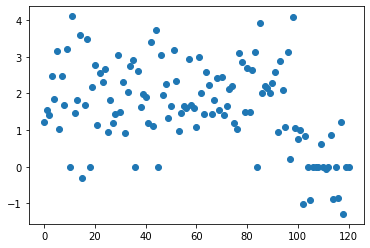

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(fit1[1])), fit1[1], 'o')
plt.show()


In [8]:
print("sensitivity:", np.sum(fit1[1][1:101]!=0)/100)
print("specificity:", np.sum(fit1[1][101:]==0)/2000)

sensitivity: 0.95
specificity: 0.004
